# 2. seq2seq

In [1]:
## 세상에는 시계열 데이터가 넘쳐난다.
## 언어, 음성, 동영상 모두 시계열 데이터이다.
## 이러한 시계열 데이터를 또 다른 시계열 데이터로 변환하는 문제를 생각해볼 수 있다.
## 기계 번역이나 음성 인식을 예로 들 수 있다.

In [2]:
## 지금부터 우리는 시계열 데이터를 다른 시계열 데이터로 변환하는 모델을 생각해볼 것이다.
## 이를 위한 기법으로 여기서는 2개의 RNN을 이용하는 seq2seq라는 방법을 살펴본다.

### seq2seq의 원리

In [3]:
## seq2seq 를 Encoder-Decoder 모델이라고도 한다.
## seq2seq 구조를 예를 들어보자

## 나는 고양이로소이다 --> Encoder --> Decoder --> I am a cat

## Encoder가 인코딩한 정보에는 번역에 필요한 정보가 응축되어 있다.
## Decoder는 이 정보를 바탕으로 번여된 문장을 생성한다.

## 이러한 Encoder와 Decoder는 RNN을 사용할 수 있다

In [4]:
## Encoder는 RNN을 이용해 시계열 데이터를 h라는 은닉 상태 벡터로 변환한다.
## Encoder가 출력하는 벡터 h는 RNN 계층의 마지막 은닉 상태이다.
## 이 마지막 은닉 상태 h에 입력문장을 번역하는 데 필요한 정보가 인코딩된다.
## 중요한 것은 이것이 고정길이 벡터라는 사실이다.
## 그래서 인코딩한다는 것은 결국 '임의 길이의 문장'을 '고정 길이 벡터'로 변환하는 작업이다.

In [5]:
## Decoder는 RNN 계층이 은닉상태 벡터 h를 입력받는다. 
## 참고로 앞 장의 언어 모델을 구현할 때는 h로 0벡터를 입력받았다.(아무것도 받지 않았다고 볼 수 있다)
## <eos>라는 구분 기호를 이용해 문장 생성의 시작을 알리는 신호 나타낸다. 또 종료 신호이기도 하다.

In [6]:
## seq2seq는 RNN 계층 두 개를 연결한 것이다.
## 이때 은닉 상태가 Encoder와 Decoder를 이어주는 가교가 된다.

### 시계열 데이터 변환용 장난감 문제

In [7]:
## 시계열 변환 문제의 예로 '더하기'를 다룰 것이다.
## "57 + 5"와 같은 문자열을 받으면 "62"라는 정답을 내놓도록 학습시킬 것이다.
## 이와 같이 머신러닝을 평가하고자 만든 간단한 문제를 '장난감 문제(toy problem)'라고 한다.

In [8]:
## seq2seq는 덧셈의 예로부터 문자의 패턴을 학습한다. 

## 우리는 지금까지 문장을 '단어' 단위로 분할해왔다.
## 그러나 문장을 반드시 단어로 분할해야 하는 건 아니다.
## 이번에는 단어가 아닌 '문자' 단위로 분할한다.
## 문자 단위 분할이란 "57 + 5"가 입력되면 ['5', '7', '+', '5']라는 리스트로 처리하는 것을 말한다.

### 가변 길이 시계열 데이터

In [9]:
## 여기서 주의할 점은 덧셈 문장이나 그 답의 문자 수가 문제마다 다르다는 거이다.
## 이번 '덧셈' 문제에서는 샘플마다 데이터의 시간 방향 크기가 다르다. (가변길이 시계열 데이터)

In [10]:
## 가변 길이 시계열 데이터를 미니배치로 학습하기 위한 가장 단순한 방법은 패딩Padding을 사용하는 것이다.
## 원래 데이터에 의미없는 데이터를 채워 모든 데이터의 길이를 균일하게 맞추는 기법이다.
## 패딩을 적용하되 정확성을 높이려면 패딩 전용 처리를 추가해야한다.
## Decoder에 패딩 데이터가 입력되면 손실에 반영하지 않도록 하고
## Encoder에 패딩 데이터가 입력되면 이전 시각의 입력을 그대로 출력하게 한다.

### 덧셈 데이터셋

In [11]:
## 덧셈 학습 데이터 dataset/addition.txt에는 덧셈 예가 총 50000개나 들어 있다.
## 실제 사용 예를 살펴보자

In [12]:
# coding: utf-8
import sys
sys.path.append('..')
from dataset import sequence


(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed = 1984)

char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
# [ 3  0  2  0  0 11  5]
# [ 6  0 11  7  5]


(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]


In [13]:
print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189

71+118 
_189 


# 3. seq2seq 구현

In [14]:
## Encoder와 Decoder를 각각 구현한 다음 연결한다.

### Encoder 클래스

In [15]:
## Encoder 클래스는 문자열을 입력 받아 벡터 h로 변환한다

In [16]:
## Encoder는 Embedding 계층과 LSTM 계층으로 구성된다.
## Embedding에서는 문자ID를 문자 벡터로 변환한다.
## 그리고 이 문자 벡터가 LSTM 계층으로 입력된다.
## LSTM 계층은 시간 방향으로는 은닉 상태(h)와 셀(c)을 출력하고 위쪽으로는 은닉 상태(h)만 출력한다.
## 여기서 LSTM 계층은 하나뿐이므로 위쪽 출력은 폐기된다. 

In [17]:
## 이제 Encoder 클래스를 구현해보자.
## 여기서 Encoder를 Time 계층으로 묶어서 구현한다.

In [20]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embedd_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        
        # Encoder를 Time 계층으로 묶어서 구현
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = False)
        
        # 파라미터와 기울기 모으기
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None
        
    ## 이번 문제에서는 Time LSTM 계층이 상태를 유지하지 않기 때문에 stateful = False로 설정한다.
    ## 앞에서 언어모델은 긴 시계열 데이터가 하나인 문제를 다뤘다.
    ## 그래서 stateful을 True로 설정하여 은닉 상태를 유지한 채로 데이터를 처리했다.
    ## 하지만 이번에는 짧은 시계열 데이터가 여러 개인 문제이기 때문에 문제마다 은닉 사태를 초기화한 상태(영벡터)로 설정한다.
    
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]
    
    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh
        
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### Decoder 클래스

In [23]:
## Decoder 클래스는 Encoder 클래스가 출력한 h를 받아 다른 문자열을 출력한다.
## Encoder와 마찬가지로 Decoder 또한 LSTM 계층을 사용하면 된다. 
## RNN으로 문장을 생성할 때, 학습 시와 생성 시의 데이터 부여 방법이 다르다.
## 학습 때는 정답을 알고 있기 때문에 시계열 방향의 데이터를 한 번에 줄 수 있다.
## 그러나 추론 시에는 최초 시작을 알리는 구분자 '_'를 하나 넣어준다.
## 그리고 그 출력으로부터 문자를 하나 샘플링하여, 다음 입력으로 사용하는 과정을 반복한다.

In [24]:
## 문장을 생성할 때는 소프트맥스 함수의 확률 분포를 바탕으로 샘플링 했기 때문에 확률적으로 문장이 달라졌다.
## 이번 문제는 덧셈이므로 결정적으로 샘플링 할 것이다.

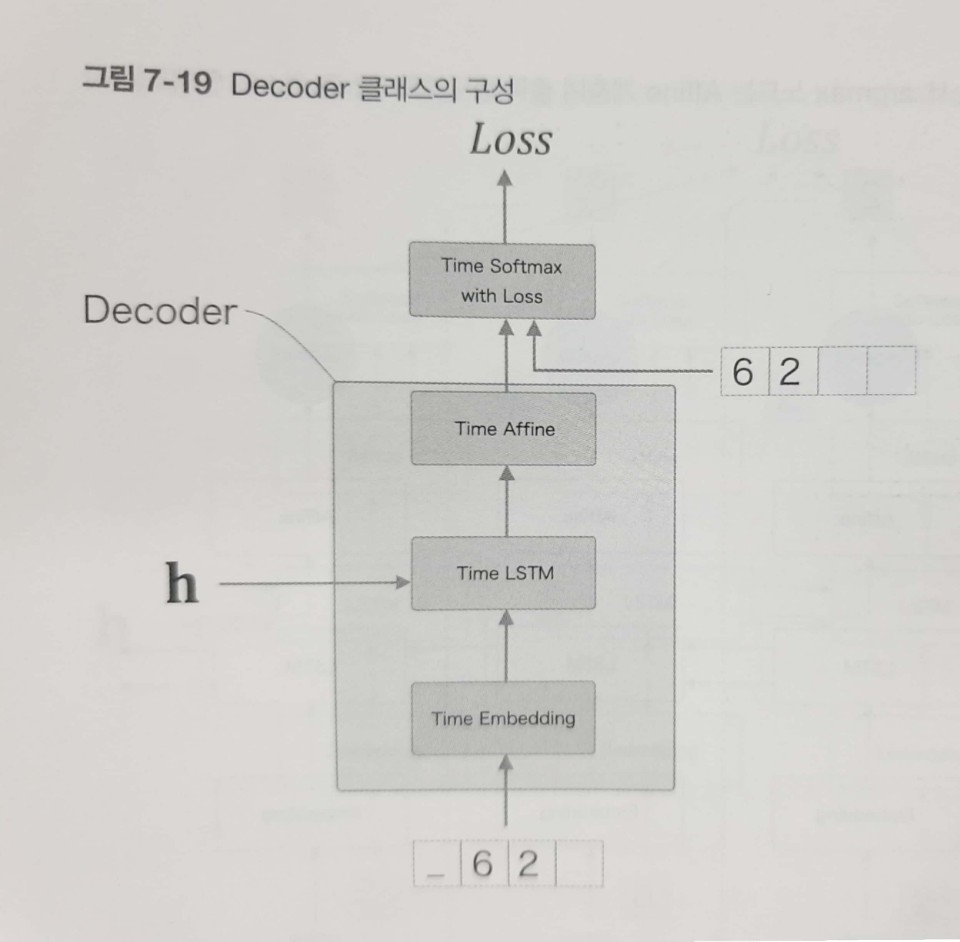

In [30]:
from IPython.display import Image

Image('Decoder.jpg', width = 380, height = 380)

In [33]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = True)
        self.affine = TimeAffine(affine_W, affine_b)
        self.params, self.grads = [], []
        
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, h):
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh
    
    ## Decoder 클래스는 학습 시와 문장 생성 시의 동작이 다르다.
    ## forward() 메서드는 학습할 때 사용한다
    ## 다음으로 Decoder 클래스에 문장 생성을 담당하는 generate() 메서드를 구현한다.
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)  ## Encoder 출력 h를 Decoder의 Time LSTM 계층의 상태로 설정
                                ## h를 유지하면서 순전파가 이뤄진다.
        
        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))
            
        return sampled

### seq2seq 클래스

In [36]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel

class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled


### seq2seq 평가

In [48]:
## 학습은 기본적인 신경망의 학습과 같은 흐름이다.
## 1. 데이터에서 미니배치 선택
## 2. 미니배치로부터 기울기 계산
## 3. 기울기를 사용해 매개변수 갱신

## Trainer 클래스를 사용해 이 규칙대로 작업을 수행한다.
## 매 에폭마다 seq2seq가 테스트 데이터를(문자열 생성을 수행하여)풀게 하여 학습 중간중간 정답률을 측정한다.
## 이 코드에서는 평가의 척도로 정답률을 사용했다.
## 정답률 측정에 사용된 메서드는 문제를 모델에 주고, 문자열을 생성하게 하여 그것이 답과 같은 지를 판단한다.
## 모델이 내놓은 답이 맞으면 1, 틀리면 0을 돌려준다.

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 3[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 4[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 5[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 6[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 6[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 7[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 8[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 9[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 9[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 10[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 11[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 11[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 12[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26

Q 77+85  
T 162 
X 156 
---
Q 975+164
T 1139
X 1160
---
Q 582+84 
T 666 
X 658 
---
Q 8+155  
T 163 
X 164 
---
Q 367+55 
T 422 
X 431 
---
Q 600+257
T 857 
X 838 
---
Q 761+292
T 1053
X 1039
---
Q 830+597
T 1427
X 1411
---
Q 26+838 
T 864 
X 868 
---
Q 143+93 
T 236 
X 227 
---
검증 정확도 5.040%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.99
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.99
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 1.00
| 에폭 9 |  반복 61 / 351 | 시간 2[s] | 손실 0.99
| 에폭 9 |  반복 81 / 351 | 시간 2[s] | 손실 0.99
| 에폭 9 |  반복 101 / 351 | 시간 3[s] | 손실 0.99
| 에폭 9 |  반복 121 / 351 | 시간 4[s] | 손실 0.99
| 에폭 9 |  반복 141 / 351 | 시간 5[s] | 손실 1.00
| 에폭 9 |  반복 161 / 351 | 시간 5[s] | 손실 0.99
| 에폭 9 |  반복 181 / 351 | 시간 6[s] | 손실 0.97
| 에폭 9 |  반복 201 / 351 | 시간 7[s] | 손실 1.01
| 에폭 9 |  반복 221 / 351 | 시간 8[s] | 손실 0.98
| 에폭 9 |  반복 241 / 351 | 시간 8[s] | 손실 0.99
| 에폭 9 |  반복 261 / 351 | 시간 9[s] | 손실 0.99
| 에폭 9 |  반복 281 / 351 | 시간 10[s] | 손실 0.97
| 에폭 9 |  반복 301 / 351 | 시간 10[s] | 손실 0.98
| 에폭 9 |  반복 321 / 351

| 에폭 16 |  반복 161 / 351 | 시간 6[s] | 손실 0.85
| 에폭 16 |  반복 181 / 351 | 시간 6[s] | 손실 0.86
| 에폭 16 |  반복 201 / 351 | 시간 7[s] | 손실 0.88
| 에폭 16 |  반복 221 / 351 | 시간 8[s] | 손실 0.89
| 에폭 16 |  반복 241 / 351 | 시간 8[s] | 손실 0.88
| 에폭 16 |  반복 261 / 351 | 시간 9[s] | 손실 0.88
| 에폭 16 |  반복 281 / 351 | 시간 10[s] | 손실 0.86
| 에폭 16 |  반복 301 / 351 | 시간 11[s] | 손실 0.84
| 에폭 16 |  반복 321 / 351 | 시간 11[s] | 손실 0.86
| 에폭 16 |  반복 341 / 351 | 시간 12[s] | 손실 0.88
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1136
---
Q 582+84 
T 666 
X 672 
---
Q 8+155  
T 163 
X 159 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 866 
---
Q 761+292
T 1053
X 1073
---
Q 830+597
T 1427
X 1424
---
Q 26+838 
T 864 
X 862 
---
Q 143+93 
T 236 
X 232 
---
검증 정확도 7.720%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.86
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.84
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.90
| 에폭 17 |  반복 61 / 351 | 시간 2[s] | 손실 0.88
| 에폭 17 |  반복 81 / 351 | 시간 2[s] | 손실 0.91
| 에폭 17 |  반복 101 / 351 | 시간 3[s] | 손실 0.87
| 에폭

검증 정확도 6.980%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.79
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.83
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.79
| 에폭 24 |  반복 61 / 351 | 시간 2[s] | 손실 0.77
| 에폭 24 |  반복 81 / 351 | 시간 3[s] | 손실 0.78
| 에폭 24 |  반복 101 / 351 | 시간 3[s] | 손실 0.78
| 에폭 24 |  반복 121 / 351 | 시간 4[s] | 손실 0.78
| 에폭 24 |  반복 141 / 351 | 시간 5[s] | 손실 0.77
| 에폭 24 |  반복 161 / 351 | 시간 6[s] | 손실 0.82
| 에폭 24 |  반복 181 / 351 | 시간 6[s] | 손실 0.86
| 에폭 24 |  반복 201 / 351 | 시간 7[s] | 손실 0.81
| 에폭 24 |  반복 221 / 351 | 시간 8[s] | 손실 0.80
| 에폭 24 |  반복 241 / 351 | 시간 9[s] | 손실 0.80
| 에폭 24 |  반복 261 / 351 | 시간 9[s] | 손실 0.81
| 에폭 24 |  반복 281 / 351 | 시간 10[s] | 손실 0.80
| 에폭 24 |  반복 301 / 351 | 시간 16[s] | 손실 0.79
| 에폭 24 |  반복 321 / 351 | 시간 18[s] | 손실 0.76
| 에폭 24 |  반복 341 / 351 | 시간 19[s] | 손실 0.76
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
X 1151
---
Q 582+84 
T 666 
X 665 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
X 427 
---
Q 600+257
T 857 
X 859 
---
Q 761+292
T 1053
X 1063
---


C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 

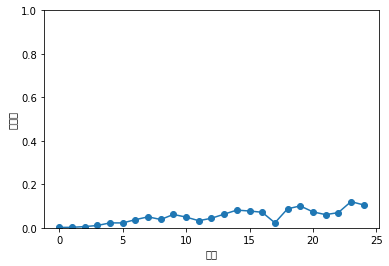

In [47]:
# coding: utf-8
import sys, os
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()



In [49]:
## 결과를 보면 에폭을 거듭함에 따라 정답률이 상승하는 것을 알 수 있다.
## 학습을 계속하면 개선의 여지가 있어 보인다. 하지만 더 빠른 학습을 할 수 있도록 seq2seq를 개선해보자

# 4. seq2seq 개선

In [51]:
## 이번 절에서는 seq2seq를 세분화하여 학습 속도를 개선하고자 한다.
## 효과적인 기법 2가지를 소개한다.

### 입력 데이터 반전(Reverse)

In [52]:
## 입력 데이터의 순서를 반전시키는 트릭이다.
## 이 트릭을 사용하면 많은 경우 학습 진행이 빨라져 결과적으로 최종 정확도도 좋아진다고 한다.

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 3[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 4[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 5[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 5[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 6[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 7[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 7[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 8[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 9[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 10[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 10[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 11[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 12[s] | 손실 1.73
Q   58+77
T 162 
X 100 
---
Q 461+579
T 1139
X 1000
---
Q  48+285
T 666 
X 1001
---
Q   551+8
T 163 
X 100 
---
Q  55+763
T 422 
X 1001
---
Q 752+006
T 857 
X 1000
---
Q 292+167
T 1053
X 1000
---
Q 795+038
T 1427
X 1000
---
Q  8

| 에폭 8 |  반복 341 / 351 | 시간 12[s] | 손실 0.57
Q   58+77
T 162 
X 163 
---
Q 461+579
T 1139
X 1134
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
X 162 
---
Q  55+763
T 422 
X 423 
---
Q 752+006
T 857 
X 759 
---
Q 292+167
T 1053
O 1053
---
Q 795+038
T 1427
X 1431
---
Q  838+62
T 864 
X 866 
---
Q  39+341
T 236 
X 238 
---
검증 정확도 23.080%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.55
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.56
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 0.56
| 에폭 9 |  반복 61 / 351 | 시간 2[s] | 손실 0.55
| 에폭 9 |  반복 81 / 351 | 시간 2[s] | 손실 0.54
| 에폭 9 |  반복 101 / 351 | 시간 3[s] | 손실 0.55
| 에폭 9 |  반복 121 / 351 | 시간 4[s] | 손실 0.55
| 에폭 9 |  반복 141 / 351 | 시간 5[s] | 손실 0.54
| 에폭 9 |  반복 161 / 351 | 시간 6[s] | 손실 0.55
| 에폭 9 |  반복 181 / 351 | 시간 6[s] | 손실 0.53
| 에폭 9 |  반복 201 / 351 | 시간 7[s] | 손실 0.54
| 에폭 9 |  반복 221 / 351 | 시간 8[s] | 손실 0.54
| 에폭 9 |  반복 241 / 351 | 시간 8[s] | 손실 0.53
| 에폭 9 |  반복 261 / 351 | 시간 9[s] | 손실 0.53
| 에폭 9 |  반복 281 / 351 | 시간 10[s] | 손실 0.54
| 에폭 9 |  반복 301 / 35

| 에폭 16 |  반복 141 / 351 | 시간 5[s] | 손실 0.36
| 에폭 16 |  반복 161 / 351 | 시간 5[s] | 손실 0.37
| 에폭 16 |  반복 181 / 351 | 시간 6[s] | 손실 0.36
| 에폭 16 |  반복 201 / 351 | 시간 7[s] | 손실 0.38
| 에폭 16 |  반복 221 / 351 | 시간 7[s] | 손실 0.38
| 에폭 16 |  반복 241 / 351 | 시간 8[s] | 손실 0.36
| 에폭 16 |  반복 261 / 351 | 시간 9[s] | 손실 0.35
| 에폭 16 |  반복 281 / 351 | 시간 10[s] | 손실 0.35
| 에폭 16 |  반복 301 / 351 | 시간 10[s] | 손실 0.35
| 에폭 16 |  반복 321 / 351 | 시간 11[s] | 손실 0.35
| 에폭 16 |  반복 341 / 351 | 시간 12[s] | 손실 0.37
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
X 1142
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
O 422 
---
Q 752+006
T 857 
X 858 
---
Q 292+167
T 1053
X 1054
---
Q 795+038
T 1427
X 1430
---
Q  838+62
T 864 
O 864 
---
Q  39+341
T 236 
X 237 
---
검증 정확도 42.700%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.34
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.36
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.36
| 에폭 17 |  반복 61 / 351 | 시간 2[s] | 손실 0.35
| 에폭 17 |  반복 81 / 351 | 시간 2[s] | 손실 0.36
| 에

검증 정확도 45.100%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.31
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.29
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.28
| 에폭 24 |  반복 61 / 351 | 시간 2[s] | 손실 0.29
| 에폭 24 |  반복 81 / 351 | 시간 2[s] | 손실 0.30
| 에폭 24 |  반복 101 / 351 | 시간 3[s] | 손실 0.29
| 에폭 24 |  반복 121 / 351 | 시간 4[s] | 손실 0.29
| 에폭 24 |  반복 141 / 351 | 시간 5[s] | 손실 0.29
| 에폭 24 |  반복 161 / 351 | 시간 5[s] | 손실 0.28
| 에폭 24 |  반복 181 / 351 | 시간 6[s] | 손실 0.29
| 에폭 24 |  반복 201 / 351 | 시간 7[s] | 손실 0.28
| 에폭 24 |  반복 221 / 351 | 시간 7[s] | 손실 0.28
| 에폭 24 |  반복 241 / 351 | 시간 8[s] | 손실 0.29
| 에폭 24 |  반복 261 / 351 | 시간 9[s] | 손실 0.29
| 에폭 24 |  반복 281 / 351 | 시간 9[s] | 손실 0.29
| 에폭 24 |  반복 301 / 351 | 시간 10[s] | 손실 0.28
| 에폭 24 |  반복 321 / 351 | 시간 11[s] | 손실 0.27
| 에폭 24 |  반복 341 / 351 | 시간 12[s] | 손실 0.29
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
X 1140
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
X 421 
---
Q 752+006
T 857 
O 857 
---
Q 292+167
T 1053
X 1054
---


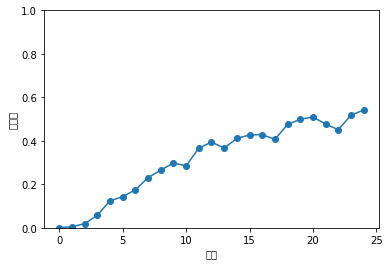

In [54]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]


# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()



In [55]:
## 배열의 행을 반전시키려면 x_train[:, ::-1]이라는 표기법을 사용하면 된다.

## 결과를 보면 입력데이터를 반전시킨 것만으로 학습이 개선됐다.
## (이론적인 것은 잘 모르지만) 아마 기울기 전파가 원활해지기 때문이라고 생각된다.
## 예를들어 나는 고양이로소이다를 번역하는 문제에서
## '나'라는 단어부터 'I'까지 가려면 '고양이', '로소', '이다'까지 총 네 단어 분량의 LSTM 계층을 거쳐야한다.
## 반전을 하면, '나'와 'I'는 바로 옆이 되었으니 기울기가 직접 전해진다.
## 이처럼 입력 문장의 첫부분에서는 번전 덕분에 대응하는 단어와 가까우므로 기울기가 잘 전해져 학습 효율이 좋아진다고 생각할 수 있다.

### 엿보기(Peeky)

In [56]:
## Encoder는 입력 문장을 고정길이 벡터 h로 변환하고 h 안에는 Decoder에게 필요한 정보가 모두 담겨 있다.
## 현재의 seq2seq에서는 Decoder의 첫 번째 LSTM 계층만이 h를 이용하고 있다.

In [57]:
## 두 번째 개선안은 h를 Decoder의 다른 계층에도 입력해주는 것이다.
## 모든 시각의 Affine 계층과 LSTM 계층에 h를 전해준다.
## 집단 지성에 비유할 수 있다. 중요한 정보를 공유하여 더 올바른 결정을 내릴 수 있는 것과 같다.

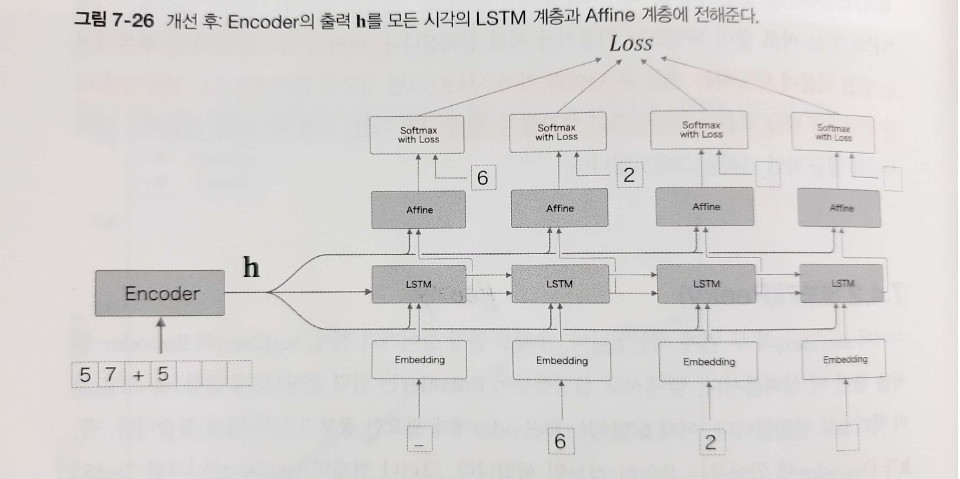

In [60]:
Image('Peeky.jpg', width = 580, height = 780)

In [62]:
## LSTM 계층과 Affine 계층에 입력되는 벡터가 2개씩이 되었다.
## 이는 실제로 두 벡터가 연결된 것을 의미한다.
## 따라서 앞의 그림은 두 벡터를 연결시키는 concat 노드를 이용해 아래와 같이 그려야 정확하다.

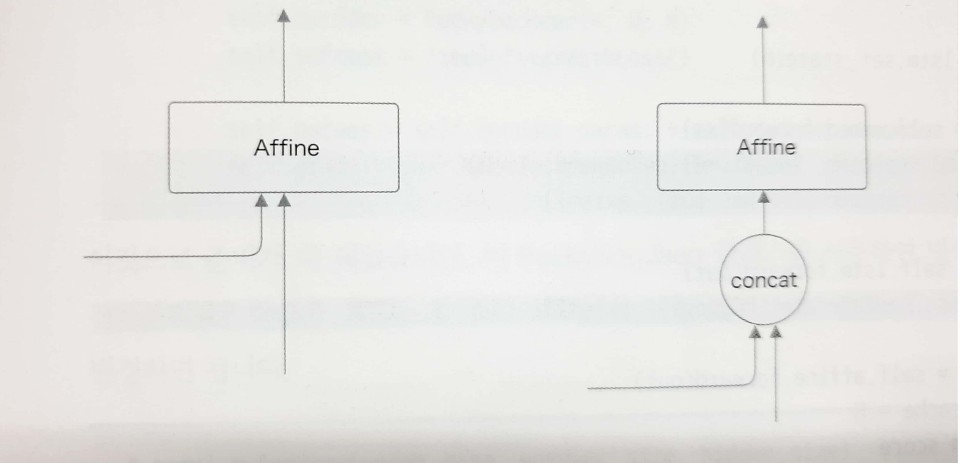

In [63]:
Image('concat.jpg', width = 480, height = 600)

In [64]:
## Peeky Decoder 클래스의 구현을 살펴보자

In [65]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from ch07.seq2seq import Seq2seq, Encoder


class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled

In [66]:
import sys
sys.path.append('..')
from common.time_layers import *
from ch07.seq2seq import Seq2seq, Encoder


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads


In [67]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]


# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()


| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 3[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 4[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 4[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 5[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 6[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 7[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 8[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 9[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 9[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 10[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 11[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 11[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 12[s] | 손실 1.73
Q   58+77
T 162 
X 100 
---
Q 461+579
T 1139
X 1000
---
Q  48+285
T 666 
X 1001
---
Q   551+8
T 163 
X 100 
---
Q  55+763
T 422 
X 1001
---
Q 752+006
T 857 
X 1000
---
Q 292+167
T 1053
X 1000
---
Q 795+038
T 1427
X 1000
---
Q  8

KeyboardInterrupt: 

In [68]:
## 이상의 실험에서 Reverse와 Peeky가 함께 효과적으로 작동하고 있을을 알 수 있다.
## 하지만 이 장에서 수행한 개선은 '작은 개선'이라고 할 수 있고
## '큰 개선'은 다음 장에서 계속할 것이다.